In [28]:
from flowAnalyzer import FlowAnalysis
import pandas as pd
import copy
import glob
import matplotlib
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [29]:
in_folder = "HSV1_Data/Rep*/"
outfolder = "HSV1_Results/"
virus = 'HSV-$\mathregular{1^{+}}$'
fa = FlowAnalysis(quiet=False)

In [30]:
individuals = True
samples = [('HT7', 'Replicate 2')]
#samples = [('Aducanumab', 'Replicate 1'), ('6E10', 'Replicate 1')]

In [31]:
import pandas as pd

def filter_df(data: pd.DataFrame, samples: list[tuple], keep=True) -> pd.DataFrame:
    """
    Filters the DataFrame to include only columns where the values in the
    'Marker' and 'Replicate' rows match the provided tuples in samples.
    
    Parameters:
    - data: pd.DataFrame - The input DataFrame
    - samples: list of tuples - Each tuple contains (Marker, Replicate)
    - keep: bool - Whether to keep (True) or exclude (False) matching columns
    
    Returns:
    - pd.DataFrame - Filtered DataFrame
    """
    if 'Marker' in data.index and 'Replicate' in data.index:
        # If Marker and Replicate are in the index, use .loc
        matching_cols = [
            (data.loc['Marker', col], data.loc['Replicate', col]) in samples for col in data.columns
        ]
        matching_cols = pd.Series(matching_cols, index=data.columns)  # Convert to a Pandas Series
        return data.loc[:, matching_cols] if keep else data.loc[:, ~matching_cols]

    elif 'Marker' in data.columns and 'Replicate' in data.columns:
        # If Marker and Replicate are columns
        matching_rows = data[['Marker', 'Replicate']].apply(tuple, axis=1).isin(samples)
        return data[matching_rows] if keep else data[~matching_rows]

    else:
        raise KeyError("Neither 'Marker' nor 'Replicate' found in index or columns.")


In [32]:
folders = glob.glob(in_folder)
folders.sort()
dfs = []
for folder, rep in zip(folders, [1,2,3]):
    df = fa.read_data(folder, Categories=['Marker', 'Condition', 'Replicate'], relabel={'Uninfected': "Mock", 'Abeta(6E10)': '6E10', 
                             'Abeta(MOAB2)': 'MOAB2', 'pTau(Ser202,Thr205)': 'AT8', 'pTau(HT7)': 'H7',
                             'pTau(Thr217)': 'pTau-217',
                             'Abeta-Soluble': 'Solanezumab', 'pTau(Ser202,Thr205)': 'AT8',
                                  'Uninfected': "Mock", 'Abeta-Full-Length': 'APP', 'Abeta(MOAB2)': 'MOAB2', 
                                  'Abeta(6E10)': '6E10', 'pTau(HT7)': 'HT7', 'pTau(Thr217)': 'pTau-217', 
                                  'pTau-T181': 'pTau-181', 'pTau-T205': 'pTau-205', 'pTau-Thr217': 'pTau-205',
                                  'pTau217': 'pTau-217', 'Rep5': 'Replicate 5', 'Rep6': 'Replicate 6',
                                  'Rep7': 'Replicate 7', 'Rep8': 'Replicate 8', 'pTau-202,205': 'AT8',
                                 'Bapinezumab': 'Bapineuzumab', 'Ganeruzumab': 'Gantenerumab', 
                                 'alpha-synuclein': 'alpha-syn', 'nTDP43': 'n-TDP43', 'cTDP43': 'c-TDP43', 'p-Tau': 'pTau',
                                    'GFAP-Biolegend': "GFAP", 'CD45-Invitrogen': 'CD45'
                                                                                       })
    df.Replicate = [f'Replicate {rep}'] * len(df)
    dfs.append(df)
data = pd.concat(dfs)  
data.to_csv(f'{outfolder}/raw_flow_values.csv', index=False)
if individuals:
    data = filter_df(data, samples)

reading in HSV1_Data/Rep1/Abeta-Full-Length_ACV_Rep3.csv...
reading in HSV1_Data/Rep1/Iba1_Uninfected_Rep1.csv...
reading in HSV1_Data/Rep1/TRA-1-60_Uninfected_Rep1.csv...
reading in HSV1_Data/Rep1/pTau-T181_Uninfected_Rep1.csv...
reading in HSV1_Data/Rep1/CD4_ACV_Rep1.csv...
reading in HSV1_Data/Rep1/Abeta(6E10)_Infected_Rep2.csv...
reading in HSV1_Data/Rep1/CD4_Infected_Rep1.csv...
reading in HSV1_Data/Rep1/CD45_Infected_Rep2.csv...
reading in HSV1_Data/Rep1/pTau-T181_ACV_Rep1.csv...
reading in HSV1_Data/Rep1/p-Tau_Infected_Rep2.csv...
reading in HSV1_Data/Rep1/pTau(Ser202,Thr205)_Infected_Rep5.csv...
reading in HSV1_Data/Rep1/Nestin_Infected_Rep2.csv...
reading in HSV1_Data/Rep1/pTau(Thr217)_ACV_Rep3.csv...
reading in HSV1_Data/Rep1/Nestin_Uninfected_Rep2.csv...
reading in HSV1_Data/Rep1/NeuN_ACV_Rep1.csv...
reading in HSV1_Data/Rep1/O4_Infected_Rep1.csv...
reading in HSV1_Data/Rep1/Abeta(MOAB2)_Infected_Rep5.csv...
reading in HSV1_Data/Rep1/Abeta-Soluble_Infected_Rep1.csv...
readin

In [33]:
category_order = ['Mock', 'Infected', 'Treated']
group = ['Marker', 'Replicate']
data.groupby(group).size()

Marker  Replicate  
HT7     Replicate 2    114953
dtype: int64

In [34]:
data = fa.apply_function(data = data, function='gate', group = group,
                         channel='FSC-A', gate_on='Mock',
                         category_order=category_order,
                         high=95, low=5, plot_title=f'Marker|Replicate', 
                         plot_path=f'{outfolder}/Marker/Replicate/', show=False, kept_min=50) 
data = fa.apply_function(data = data, function='gate', group = group,
                         channel='SSC-A', gate_on='Mock',
                         category_order=category_order,
                         high=95, low=5, plot_title=f'Marker|Replicate', 
                         plot_path=f'{outfolder}/Marker/Replicate/', show=False, kept_min=50) 
data = data[data['gate FSC-A']&data['gate SSC-A']]

('HT7', 'Replicate 2')
89.95551318716237
One Peak
('HT7', 'Replicate 2')
89.9621667067019
One Peak


In [35]:
data = fa.apply_function(data=data, function='gate_singlets',
                         group = group,
                         category_order=category_order,
                         plot_title=f'Marker|Replicate',
                         plot_path=f'{outfolder}/Marker/Replicate/',
                         show=False)

data = data[data['Singlet']]
if not individuals:
    data.to_csv(f'{outfolder}/valid_cells_flow_values.csv', index=False)
else:
    old_data = pd.read_csv(f'{outfolder}/valid_cells_flow_values.csv', dtype={"Marker": str})
    old_data = filter_df(old_data, samples, False)
    old_data = pd.concat((old_data, data))
    old_data.to_csv(f'{outfolder}/valid_cells_flow_values.csv', index=False)

('HT7', 'Replicate 2')


In [36]:
data = fa.apply_function(data = data, function='gate', group = group,
                         channel='Pacific Blue-A', gate_on='Mock',
                         category_order=category_order,
                         high=85, plot_title=f'Marker|Replicate', 
                         plot_path=f'{outfolder}/Marker/Replicate', show=False, kept_max=85) 
data = fa.apply_function(data = data, function='gate', group = group,
                         channel='Alexa Fluor 488-A', gate_on='Infected',
                         category_order=category_order,
                         high=85, plot_title=f'Marker|Replicate', 
                         plot_path=f'{outfolder}/Marker/Replicate', show=False, mid_percentile=99, secondary_gate='Treated',kept_max=85) 
data = fa.apply_function(data = data, function='gate', group = group,
                         channel='Alexa Fluor 647-A', gate_on='Mock',
                         category_order=category_order, secondary_gate='Treated',
                         high=85, plot_title=f'Marker|Replicate', 
                         plot_path=f'{outfolder}/Marker/Replicate', show=False, kept_max=85) 


('HT7', 'Replicate 2')
15.071200935898988
One Peak
('HT7', 'Replicate 2')
15.390862076334571
One Peak
('HT7', 'Replicate 2')
15.04699665174069
One Peak


In [10]:
if not individuals:
    data.to_csv(f'{outfolder}/all_cells_gated_cells_flow_values.csv', index=False)
else:
    old_data = pd.read_csv(f'{outfolder}/all_cells_gated_cells_flow_values.csv', dtype={"Marker": str})
    old_data = filter_df(old_data, samples, False)
    old_data = pd.concat((old_data, data))
    old_data.to_csv(f'{outfolder}/all_cells_gated_cells_flow_values.csv', index=False)
data

Alexa Fluor 488-A  Alexa Fluor 647-A  Pacific Blue-A     FSC-A  \
0                  334.0              556.0           206.0  2.230449   
1                  364.0              424.0           404.0  2.559907   
2                  574.0              380.0           394.0  2.459392   
3                  507.0              466.0           823.0  2.423246   
4                  597.0              429.0           351.0  2.591065   
...                  ...                ...             ...       ...   
66163              302.0              264.0           782.0  2.173186   
66164              314.0              461.0           392.0  1.991226   
66165              673.0              651.0           455.0  2.230449   
66166              262.0              778.0           379.0  1.968483   
66167              342.0              452.0           408.0  2.220108   

          FSC-H     SSC-A     SSC-H Marker Condition    Replicate  gate FSC-A  \
0      2.130334  1.792392  1.716003    AT8  Infected  Replicate 1        True   
1      2.472756  2.225309  2.133539    AT8  Infected  Replicate 1        True   
2      2.383815  2.173186  2.100371    AT8  Infected  Replicate 1        True   
3      2.346353  2.285557  2.225309    AT8  Infected  Replicate 1        True   
4      2.563481  1.908485  1.875061    AT8  Infected  Replicate 1        True   
...         ...       ...       ...    ...       ...          ...         ...   
66163  2.117271  2.049218  2.017033    AT8   Treated  Replicate 1        True   
66164  1.903090  2.167317  2.045323    AT8   Treated  Replicate 1        True   
66165  2.117271  2.334454  2.217484    AT8   Treated  Replicate 1        True   
66166  1.838849  1.880814  1.763428    AT8   Treated  Replicate 1        True   
66167  2.143015  2.201397  2.100371    AT8   Treated  Replicate 1        True   

       gate SSC-A  predicted  residuals  Singlet  gate Pacific Blue-A  \
0            True   2.141800  -0.011467     True                False   
1            True   2.465638   0.007118     True                False   
2            True   2.366839   0.016977     True                False   
3            True   2.331309   0.015044     True                 True   
4            True   2.496265   0.067216     True                False   
...           ...        ...        ...      ...                  ...   
66163        True   2.092758   0.024513     True                 True   
66164        True   1.916136  -0.013046     True                False   
66165        True   2.148341  -0.031070     True                False   
66166        True   1.894060  -0.055211     True                False   
66167        True   2.138304   0.004711     True                False   

       gate Alexa Fluor 488-A  BGM  gate Alexa Fluor 647-A  
0                       False  2.0                   False  
1                       False  2.0                   False  
2                       False  0.0                   False  
3                       False  2.0                   False  
4                       False  0.0                   False  
...                       ...  ...                     ...  
66163                   False  NaN                   False  
66164                   False  NaN                   False  
66165                    True  NaN                    True  
66166                   False  NaN                    True  
66167                   False  NaN                   False  

[66168 rows x 19 columns]

In [11]:
#label each cell as live or dead based on Pacific Blue-A gate

correlations_df = fa.apply_function(data=data, function='calc_correlation',
                                    group = group,
                                    category_order=category_order,
                                    control_channel='Alexa Fluor 488-A',
                                    control='Mock',
                                    cols=['Alexa Fluor 488-A', 'Alexa Fluor 647-A'],
                                    rows=['Alexa Fluor 647-A', 'Pacific Blue-A'],
                                    col_labels= [virus, 'Marker'], 
                                    row_labels = ['Marker', 'Dead'],
                                    plot_title='Marker|Replicate', 
                                    plot_path=f'{outfolder}/Marker/Replicate',
                                    show=False, include_colorbar=False
                        )

if not individuals:
    correlations_df.to_csv(f'{outfolder}/all_cells_correlations.csv', index=False)
else:
    old_data = pd.read_csv(f'{outfolder}/all_cells_correlations.csv', dtype={"Marker": str})
    old_data = filter_df(old_data, samples, False)
    old_data = pd.concat((old_data, correlations_df))
    old_data.to_csv(f'{outfolder}/all_cells_correlations.csv', index=False)


corrected_df = fa.apply_function(data=data, function='calc_correlation',
                                group=group,
                                control_channel='Alexa Fluor 488-A',
                                category_order=category_order,
                                control='Mock',
                                correct_only=True,
                                undo_normalization=True)
corrected_df = corrected_df.rename(columns={'Alexa Fluor 488-A': 'Normalized Alexa Fluor 488-A', 
                                            'Alexa Fluor 647-A':'Corrected Alexa Fluor 647-A', 
                                            'Pacific Blue-A': 'Corrected Pacific Blue-A'})


if not individuals:
    corrected_df.to_csv(f'{outfolder}/all_cells_linear_corrected_values.csv', index=False)
else:
    old_data = pd.read_csv(f'{outfolder}/all_cells_linear_corrected_values.csv', dtype={"Marker": str})
    old_data = filter_df(old_data, samples, False)
    old_data = pd.concat((old_data, corrected_df))
    old_data.to_csv(f'{outfolder}/all_cells_linear_corrected_values.csv', index=False)



('AT8', 'Replicate 1')
('AT8', 'Replicate 1')


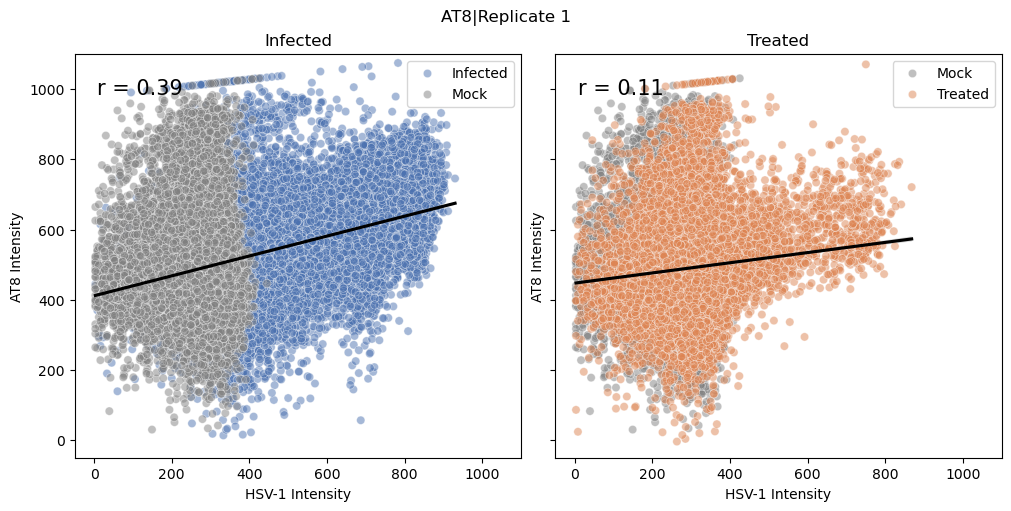

In [14]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd

custom_palette = {
    'Infected': '#4C72B0',
    'Treated': '#DD8452',
    'Mock': 'gray'
}
corrected_df = pd.read_csv('HSV1_Results/all_cells_linear_corrected_values.csv', dtype={'Marker': str})
if individuals:
    corrected_df = filter_df(corrected_df, samples)
for (marker, rep), df in corrected_df.groupby(['Marker', 'Replicate']):
    marker = str(marker)
    fig, axes = plt.subplots(ncols=2, figsize=(10,5), sharex=True, sharey=True,
                            gridspec_kw={'width_ratios':[1,1]}, constrained_layout=True)
    for condition, ax in zip(['Infected', 'Treated'],axes):
        marker_label = marker.replace(':', '/')
        condition_data = df[(df.Condition==condition)|(df.Condition=='Mock')]
        x = condition_data['Normalized Alexa Fluor 488-A']
        y = condition_data['Corrected Alexa Fluor 647-A']
        ax.set_xlim(-50, 1100)
        ax.set_ylim(-50, 1100)
        if len(x) < 1 or len(y) < 1:
            continue
        r,p = stats.pearsonr(x,y)
        
        sns.regplot(condition_data, x= 'Normalized Alexa Fluor 488-A', y='Corrected Alexa Fluor 647-A', ax=ax,
                    scatter=False, color='k')
        sns.scatterplot(condition_data, x= 'Normalized Alexa Fluor 488-A', y='Corrected Alexa Fluor 647-A', ax=ax,
                        alpha=0.5, hue='Condition', palette=custom_palette
             )
        
        ax.set_title(condition)
        ax.set_xlabel('HSV-1 Intensity')
        ax.set_ylabel(f'{marker} Intensity')
        ax.text(.05, .9, 'r = {:.2f}'.format(r, p),
            transform=ax.transAxes, size=15
               )
        ax.legend(loc='upper right')
    if marker == 'Abeta-Full-Length':
        marker = 'APP'
    out_path = f'{outfolder}/{marker}/{rep}/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
   # plt.tight_layout()
    plt.suptitle(f'{marker_label}|{rep}'.replace('Abeta', 'Aβ42'))
    plt.savefig(f'{out_path}/correlation_scatter_plot.png', dpi=700, transparent=True)
    
    plt.show()
    

In [15]:
umap_df = fa.apply_function(data=data, function='calc_umap',
                           group = group)

if not individuals:
    umap_df.to_csv(f'{outfolder}/all_cells_umap.csv', index=False)
else:
    old_data = pd.read_csv(f'{outfolder}/all_cells_umap.csv', dtype={"Marker": str})
    old_data = filter_df(old_data, samples, False)
    old_data = pd.concat((old_data, umap_df))
    old_data.to_csv(f'{outfolder}/all_cells_umap.csv', index=False)
umap_df

('AT8', 'Replicate 1')


FSC-A     FSC-H     SSC-A     SSC-H Marker Condition    Replicate  \
0      2.230449  2.130334  1.792392  1.716003    AT8  Infected  Replicate 1   
1      2.559907  2.472756  2.225309  2.133539    AT8  Infected  Replicate 1   
2      2.459392  2.383815  2.173186  2.100371    AT8  Infected  Replicate 1   
3      2.423246  2.346353  2.285557  2.225309    AT8  Infected  Replicate 1   
4      2.591065  2.563481  1.908485  1.875061    AT8  Infected  Replicate 1   
...         ...       ...       ...       ...    ...       ...          ...   
66163  2.173186  2.117271  2.049218  2.017033    AT8   Treated  Replicate 1   
66164  1.991226  1.903090  2.167317  2.045323    AT8   Treated  Replicate 1   
66165  2.230449  2.117271  2.334454  2.217484    AT8   Treated  Replicate 1   
66166  1.968483  1.838849  1.880814  1.763428    AT8   Treated  Replicate 1   
66167  2.220108  2.143015  2.201397  2.100371    AT8   Treated  Replicate 1   

       gate FSC-A  gate SSC-A  predicted  ...  Singlet  gate Pacific Blue-A  \
0            True        True   2.141800  ...     True                False   
1            True        True   2.465638  ...     True                False   
2            True        True   2.366839  ...     True                False   
3            True        True   2.331309  ...     True                 True   
4            True        True   2.496265  ...     True                False   
...           ...         ...        ...  ...      ...                  ...   
66163        True        True   2.092758  ...     True                 True   
66164        True        True   1.916136  ...     True                False   
66165        True        True   2.148341  ...     True                False   
66166        True        True   1.894060  ...     True                False   
66167        True        True   2.138304  ...     True                False   

       gate Alexa Fluor 488-A  BGM  gate Alexa Fluor 647-A  Alexa Fluor 488-A  \
0                       False  2.0                   False           0.357066   
1                       False  2.0                   False           0.389428   
2                       False  0.0                   False           0.615965   
3                       False  2.0                   False           0.543689   
4                       False  0.0                   False           0.640777   
...                       ...  ...                     ...                ...   
66163                   False  NaN                   False           0.322546   
66164                   False  NaN                   False           0.335491   
66165                    True  NaN                    True           0.722762   
66166                   False  NaN                    True           0.279396   
66167                   False  NaN                   False           0.365696   

       Alexa Fluor 647-A  Pacific Blue-A      UMAP1      UMAP2  
0               0.539901        0.227891  17.370800   4.728819  
1               0.409852        0.452381   7.709693   1.981930  
2               0.366502        0.441043   4.124095   8.474330  
3               0.451232        0.927438  -2.937087   4.263623  
4               0.414778        0.392290   3.502902  10.365046  
...                  ...             ...        ...        ...  
66163           0.252217        0.880952  -0.483142  -1.434108  
66164           0.446305        0.438776  10.411201   1.227962  
66165           0.633498        0.510204   2.456642  14.337667  
66166           0.758621        0.424036  12.703249  10.979886  
66167           0.437438        0.456916   8.135542   2.190477  

[66168 rows x 21 columns]

In [16]:
fa.apply_function(data=umap_df, function='plot_umap',
                 group=group,
                  plot_path=f'{outfolder}/Marker/Replicate', show=False, 
                  category_order = category_order, channel_labels=['Marker', virus, 'Dead']
                 )

('AT8', 'Replicate 1')


In [18]:
#label each cell as live or dead based on Pacific Blue-A gate
data = pd.read_csv('HSV1_Results/all_cells_gated_cells_flow_values.csv', dtype={'Marker': str})
if individuals:
    data = filter_df(data, samples)
quad_data = fa.apply_function(data=data, function='assign_quadrants',
                         group = group,
                         category_order=category_order,
                         plot_title=f'Marker|Replicate', 
                         plot_path=f'{outfolder}/Marker/Replicate', 
                         show=False
                        )


if not individuals:
    quad_data.to_csv(f'{outfolder}/all_cells_quadrant_counts.csv', index=False)
else:
    old_data = pd.read_csv(f'{outfolder}/all_cells_quadrant_counts.csv', dtype={"Marker": str})
    old_data = filter_df(old_data, samples, False)
    old_data = pd.concat((old_data, quad_data))
    old_data.to_csv(f'{outfolder}/all_cells_quadrant_counts.csv', index=False)


('AT8', 'Replicate 1')
